# Augmented copyPaste HuBERT-SER model

Fine-tune Hubert model on the RAVDESS dataset using copyPaste Method.
The Neutral CopyPaste (N-CP) augmentation method, introduced in Pappagari et al., 2021, is an innovative data augmentation technique designed to enhance speech emotion recognition (SER) by incorporating emotional segments into neutral utterances. This method is based on the principle that humans tend to perceive an entire utterance as emotionally charged if a distinct emotional segment appears within it, even if only briefly. However, computational models do not inherently operate this way; they rely on statistical patterns, which can introduce biases. Many emotions are not consistently present throughout an utterance but appear only in specific segments, making it challenging for models to recognize emotions in mixed contexts.

To address this, N-CP divides a neutral utterance into three equal parts and replaces the middle segment with a short emotional excerpt while keeping the neutral portions at the beginning and end unchanged. This process generates new training examples where the model must identify emotions within a mixed context, improving its ability to detect emotions that are not dominant throughout the entire utterance. Additionally, N-CP expands the dataset by increasing the number of emotional examples without reducing the availability of neutral utterances, as it does not remove existing data but rather creates new variations. To maintain balance in the training process and prevent excessive bias toward emotions, N-CP is applied selectively to a controlled portion of the dataset, ensuring that the model learns from a diverse and representative sample of speech.

#### **Flow**:

This program will follow the steps:
1. General Preparation  
2. Data Processing
3. Augmentation Method - copyPaste - ncp  
5. Loading the Model and Optimizer
6. Training
7. Testing
8. Testing all test sets

## 1. General Preparation

In [ ]:
# Install required packages
%%capture
!pip install datasets transformers evaluate accelerate torch
!pip install torch torchaudio

Import some common libraries.

In [ ]:
import time
from tqdm import tqdm
import torch
import os
import soundfile as sf
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import Wav2Vec2FeatureExtractor, HubertForSequenceClassification
from datasets import Dataset
from torch.optim import AdamW
from torch.utils.data import DataLoader
import librosa
from sklearn.metrics import classification_report, confusion_matrix
import IPython.display as ipd
import librosa
import librosa.display
import matplotlib.pyplot as plt
from IPython.display import Audio

Use GPU Facilities.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

Set Seed for Reproducibility

In [ ]:
SEED = 42

def set_seeds(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seeds(SEED)

Mount drive

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')
BASE_DIR = "/content/drive/MyDrive/YourProject"

Mounted at /content/drive


## 2. Data Processing

### 2.1 Load RAVDESS dataset

Download dataset file from website https://zenodo.org/record/1188976

In [ ]:
%%capture
![ -f Audio_Speech_Actors_01-24.zip ] && echo "File existed" || wget "https://zenodo.org/record/1188976/files/Audio_Speech_Actors_01-24.zip?download=1" -O Audio_Speech_Actors_01-24.zip

Unzip dataset file.

In [ ]:
%%capture
![ -f "./Audio_Speech_Actors_01-24/Actor_01/03-01-01-01-01-01-01.wav" ] && echo "File existed" || unzip Audio_Speech_Actors_01-24.zip -d "./Audio_Speech_Actors_01-24/"

### 2.2 Create RAVDESS data frame

In [ ]:
# Process dataset
RAV = "./Audio_Speech_Actors_01-24/"
dir_list = os.listdir(RAV)
dir_list.sort()

emotion = []
gender = []
path = []
for i in dir_list:
   fname = os.listdir(RAV + i)
   for f in fname:
       part = f.split('.')[0].split('-')
       emotion.append(int(part[2]))
       temp = int(part[6])
       gender.append("female" if temp%2 == 0 else "male")
       path.append(RAV + i + '/' + f)

# Create DataFrame
RAV_df = pd.DataFrame(emotion)
RAV_df = RAV_df.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'})
RAV_df = pd.concat([pd.DataFrame(gender), RAV_df, pd.DataFrame(emotion)],axis=1)
RAV_df.columns = ['gender','emotion','labels']
RAV_df['source'] = 'RAVDESS'
RAV_df = pd.concat([RAV_df,pd.DataFrame(path, columns = ['path'])],axis=1)
RAV_df.emotion.value_counts()

,count
emotion,
fear,192
surprise,192
calm,192
happy,192
angry,192
disgust,192
sad,192
neutral,96


In [ ]:
RAV_df

,gender,emotion,labels,source,path
0,male,fear,6,RAVDESS,./Audio_Speech_Actors_01-24/Actor_01/03-01-06-...
1,male,surprise,8,RAVDESS,./Audio_Speech_Actors_01-24/Actor_01/03-01-08-...
2,male,calm,2,RAVDESS,./Audio_Speech_Actors_01-24/Actor_01/03-01-02-...
3,male,fear,6,RAVDESS,./Audio_Speech_Actors_01-24/Actor_01/03-01-06-...
4,male,neutral,1,RAVDESS,./Audio_Speech_Actors_01-24/Actor_01/03-01-01-...
...,...,...,...,...,...
1435,female,angry,5,RAVDESS,./Audio_Speech_Actors_01-24/Actor_24/03-01-05-...
1436,female,sad,4,RAVDESS,./Audio_Speech_Actors_01-24/Actor_24/03-01-04-...
1437,female,neutral,1,RAVDESS,./Audio_Speech_Actors_01-24/Actor_24/03-01-01-...
1438,female,angry,5,RAVDESS,./Audio_Speech_Actors_01-24/Actor_24/03-01-05-...


In our project we examine 7 emotions:

In [ ]:
RAV_df = RAV_df[
   (RAV_df["emotion"]=="neutral") |
   (RAV_df["emotion"]=="happy") |
   (RAV_df["emotion"]=="sad") |
   (RAV_df["emotion"]=="angry") |
   (RAV_df["emotion"]=="fear") |
   (RAV_df["emotion"]=="disgust") |
   (RAV_df["emotion"]=="surprise")
]
print(f"Shape of data frame: {RAV_df.shape}")
RAV_df.emotion.value_counts()

Shape of data frame: (1248, 5)


,count
emotion,
fear,192
surprise,192
happy,192
angry,192
disgust,192
sad,192
neutral,96


### 2.3 Spliting the data
Split into training (80%) and test (20%) data.

In [ ]:
from sklearn.model_selection import train_test_split

# Assuming RAV_df has a column named 'labels' for stratification
train_df, test_df = train_test_split(
    RAV_df,
    test_size=0.2,
    random_state=42,
    stratify=RAV_df['emotion']
)

Let's have a look at the training data.

In [ ]:
train_df

,gender,emotion,labels,source,path
316,female,happy,3,RAVDESS,./Audio_Speech_Actors_01-24/Actor_06/03-01-03-...
992,male,happy,3,RAVDESS,./Audio_Speech_Actors_01-24/Actor_17/03-01-03-...
945,female,angry,5,RAVDESS,./Audio_Speech_Actors_01-24/Actor_16/03-01-05-...
285,male,surprise,8,RAVDESS,./Audio_Speech_Actors_01-24/Actor_05/03-01-08-...
130,male,surprise,8,RAVDESS,./Audio_Speech_Actors_01-24/Actor_03/03-01-08-...
...,...,...,...,...,...
381,male,surprise,8,RAVDESS,./Audio_Speech_Actors_01-24/Actor_07/03-01-08-...
1079,female,sad,4,RAVDESS,./Audio_Speech_Actors_01-24/Actor_18/03-01-04-...
1188,female,sad,4,RAVDESS,./Audio_Speech_Actors_01-24/Actor_20/03-01-04-...
1070,female,surprise,8,RAVDESS,./Audio_Speech_Actors_01-24/Actor_18/03-01-08-...


In [ ]:
train_df["emotion"].value_counts()

,count
emotion,
angry,154
surprise,154
disgust,154
happy,153
fear,153
sad,153
neutral,77


In [ ]:
# Display the first data.
import IPython.display as ipd
id = 0
print(train_df.iloc[id])
ipd.Audio(data=train_df.iloc[id]["path"], autoplay=True, rate=16000)

gender                                                female
emotion                                                happy
labels                                                     3
source                                               RAVDESS
path       ./Audio_Speech_Actors_01-24/Actor_06/03-01-03-...
Name: 316, dtype: object


## 3. Augmentation Method - copyPaste - ncp

In [ ]:
import numpy as np
import librosa
import matplotlib.pyplot as plt
from IPython.display import Audio, display

def ncp_augmentation(emotional_audio: np.ndarray,
                         neutral_audio: np.ndarray) -> np.ndarray:
    """
    Apply Neutral-CopyPaste augmentation to create an emotionally augmented utterance.

    Args:
        emotional_audio: Source array containing emotional speech
        neutral_audio: Target array containing neutral speech to be augmented

    Returns:
        Augmented audio array with emotional segment inserted
    """
    # Calculate the length of each part (divide neutral into three equal parts)
    part_length = len(neutral_audio) // 3

    # Extract the three parts of neutral audio
    neutral_part1 = neutral_audio[0:part_length]
    neutral_part3 = neutral_audio[2*part_length:3*part_length]

    # Extract matching length segment from emotional audio
    emotional_start = (len(emotional_audio) - part_length) // 2
    emotional_segment = emotional_audio[emotional_start:emotional_start + part_length]

    # Create the result by concatenating parts
    result = np.concatenate([
        neutral_part1,      # First part: neutral
        emotional_segment,  # Middle part: emotional
        neutral_part3       # Last part: neutral
    ])

    return result

### **Apply augmentation to data frames**

Our Neutral-CopyPaste (NCP) dataset augmentation implementation differs fundamentally from conventional single-sample augmentation methods. To construct the augmented dataset, we first enumerate all possible pairings between neutral and emotional utterances from the source dataset. From this comprehensive pool of combinations, we select samples proportionally to preserve the original emotional class distribution, ensuring each neutral-emotional pair is used exactly once. This approach doubles the dataset size while maintaining emotional balance and avoiding sample repetition.

In [ ]:
def create_augmented_df_sample_ncp(df: pd.DataFrame, split: str, SEED: int = 42) -> pd.DataFrame:
    np.random.seed(SEED)
    save_dir = f"augmented/{split}/ncp"
    os.makedirs(save_dir, exist_ok=True)

    # Separate neutral and emotional samples
    neutral_samples = df[df['emotion'] == 'neutral']
    emotional_samples = df[df['emotion'] != 'neutral']

    # Calculate exact target counts
    total_samples_needed = len(df)
    emotion_distribution = emotional_samples['emotion'].value_counts(normalize=True)

    # First, get the raw counts
    target_counts = (emotion_distribution * total_samples_needed)

    # Floor all values first
    base_counts = target_counts.astype(int)

    # Calculate remaining samples needed
    remaining = total_samples_needed - base_counts.sum()

    # Distribute remaining samples to emotions with largest decimal parts
    decimals = target_counts - base_counts
    top_decimals = decimals.nlargest(remaining)

    # Create final target counts
    final_target_counts = base_counts.copy()
    final_target_counts[top_decimals.index] += 1

    # Rest of the function remains the same...
    combinations = []
    for _, emotional_row in emotional_samples.iterrows():
        for _, neutral_row in neutral_samples.iterrows():
            combinations.append({
                'emotional_row': emotional_row,
                'neutral_row': neutral_row,
                'emotion': emotional_row['emotion']
            })

    np.random.shuffle(combinations)
    augmented_rows = []
    selected_combos = set()

    for emotion, target_count in final_target_counts.items():
        emotion_combinations = [combo for combo in combinations if combo['emotion'] == emotion]
        count = 0

        for combo in emotion_combinations:
            if count >= target_count:
                break

            combo_id = f"{combo['neutral_row'].name}_{combo['emotional_row'].name}"
            if combo_id in selected_combos:
                continue

            neutral_audio, sr = librosa.load(combo['neutral_row']['path'], sr=16000)
            emotional_audio, _ = librosa.load(combo['emotional_row']['path'], sr=16000)
            aug_audio = ncp_augmentation(emotional_audio, neutral_audio)

            aug_path = os.path.join(save_dir, f"{combo_id}_{emotion}.wav")
            sf.write(aug_path, aug_audio, sr)

            new_row = {
                'gender': combo['neutral_row']['gender'],
                'emotion': emotion,
                'labels': combo['emotional_row']['labels'],
                'source': 'ncp',
                'path': aug_path,
                'aug_type': 'ncp',
                'aug_params': {
                    'neutral_id': combo['neutral_row'].name,
                    'emotional_id': combo['emotional_row'].name,
                    'emotional_type': emotion
                }
            }
            augmented_rows.append(new_row)
            selected_combos.add(combo_id)
            count += 1

    result_df = pd.DataFrame(augmented_rows)
    assert len(result_df) == len(df), f"Generated {len(result_df)} samples instead of {len(df)}"
    return result_df

Creation of 1:1 train and test sets

In [ ]:
# For train set
train_ncp_df = create_augmented_df_sample_ncp(train_df, 'train')

# For test set
test_ncp_df = create_augmented_df_sample_ncp(test_df, 'test')

In [ ]:
print(len(train_ncp_df))
print(len(train_df))

998
998


In [ ]:
# First, add augmentation info to original dataframes
train_df['aug_type'] = 'clean'
train_df['aug_params'] = None

test_df['aug_type'] = 'clean'
test_df['aug_params'] = None

In [ ]:
# For training set
train_combined_ncp = pd.concat([train_df, train_ncp_df], ignore_index=True)

# For test set
test_combined_ncp = pd.concat([test_df, test_ncp_df], ignore_index=True)

print("Training sets:")
print(f"Original: {len(train_df)}")
print(f"NCP combined: {len(train_combined_ncp)}")
print(train_combined_ncp.head())

Training sets:
Original: 998
NCP combined: 1996
   gender   emotion  labels   source  \
0  female     happy       3  RAVDESS   
1    male     happy       3  RAVDESS   
2  female     angry       5  RAVDESS   
3    male  surprise       8  RAVDESS   
4    male  surprise       8  RAVDESS   

                                                path aug_type aug_params  
0  ./Audio_Speech_Actors_01-24/Actor_06/03-01-03-...    clean       None  
1  ./Audio_Speech_Actors_01-24/Actor_17/03-01-03-...    clean       None  
2  ./Audio_Speech_Actors_01-24/Actor_16/03-01-05-...    clean       None  
3  ./Audio_Speech_Actors_01-24/Actor_05/03-01-08-...    clean       None  
4  ./Audio_Speech_Actors_01-24/Actor_03/03-01-08-...    clean       None  


**Save datasets with audio**

In [ ]:
import os
import shutil
import pandas as pd
import pickle

def save_test_sets_with_audio(test_sets, base_save_dir='test_sets_backup'):
    """
    Saves test sets and their audio files in an organized folder structure

    Args:
        test_sets: Your dictionary containing all test DataFrames (clean, noise, etc.)
        base_save_dir: The main folder where everything will be saved
    """
    # Create the main folder if it doesn't exist
    os.makedirs(base_save_dir, exist_ok=True)

    # Go through each test set (clean, noise, etc.)
    for set_name, df in test_sets.items():
        # Create a folder for this specific test set
        set_folder = os.path.join(base_save_dir, set_name.replace(' ', '_'))
        os.makedirs(set_folder, exist_ok=True)

        # Create an audio folder inside the test set folder
        audio_folder = os.path.join(set_folder, 'audio')
        os.makedirs(audio_folder, exist_ok=True)

        # Make a copy of the DataFrame to update paths
        new_df = df.copy()

        # Go through each row in the DataFrame
        for idx, row in df.iterrows():
            # Get the audio file name from the original path
            audio_file = os.path.basename(row['path'])

            # Copy the audio file to our new audio folder
            shutil.copy2(row['path'], os.path.join(audio_folder, audio_file))

            # Update the path in the DataFrame to point to the new location
            new_df.at[idx, 'path'] = os.path.join(audio_folder, audio_file)

        # Save the updated DataFrame
        new_df.to_pickle(os.path.join(set_folder, 'metadata.pkl'))

In [ ]:
test_sets_ncp = {
    'NCP': test_ncp_df,
    'Combined NCP': test_combined_ncp
}

save_test_sets_with_audio(test_sets_ncp, base_save_dir='/content/drive/MyDrive/HuBERT_for_SER/Baseline/test_sets')

Trainset for NCP

In [ ]:
train_set_ncp = {
    'NCP': train_ncp_df,
    'Combined NCP': train_combined_ncp
}

save_test_sets_with_audio(train_set_ncp, base_save_dir='/content/drive/MyDrive/HuBERT_for_SER/Trainsets')

### 2.5 Turn data into a Dataset object

Define a Dataset class.

In [ ]:
# Dataset class
class EmotionDataset(torch.utils.data.Dataset):
   def __init__(self, encodings, labels):
       self.encodings = encodings
       pattern = {
           1: 0,  # neutral
           2: 0,  # neutral
           3: 1,  # happy
           4: 2,  # sad
           5: 3,  # angry
           6: 4,  # fear
           7: 5,  # disgust
           8: 6   # surprise
       }
       self.labels = [pattern[x] for x in labels]

   def __getitem__(self, idx):
       item = {key: val[idx] for key, val in self.encodings.items()}
       item['labels'] = torch.tensor(self.labels[idx])
       return item

   def __len__(self):
       return len(self.labels)

train_dataset = EmotionDataset(train_encodings, list(train_data["labels"]))
test_dataset = EmotionDataset(test_encodings, list(test_data["labels"]))

In [ ]:
print(train_dataset)
print(test_dataset)

## 4. Loading the Model and Optimizer

**Base model to fine-tuned**

```
model = HubertForSequenceClassification.from_pretrained(
   "superb/hubert-large-superb-er",
   num_labels=7,
   ignore_mismatched_sizes=True
)
```

In [ ]:
# Loading the model
model = HubertForSequenceClassification.from_pretrained(
   "superb/hubert-large-superb-er",
   num_labels=7,
   ignore_mismatched_sizes=True
)
model.to(device)

# Loading the optimizer
optim = AdamW(model.parameters(), lr=1e-5)

config.json:   0%|          | 0.00/1.83k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.26G [00:00<?, ?B/s]

Some weights of HubertForSequenceClassification were not initialized from the model checkpoint at superb/hubert-large-superb-er and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([4, 256]) in the checkpoint and torch.Size([7, 256]) in the model instantiated
- classifier.bias: found shape torch.Size([4]) in the checkpoint and torch.Size([7]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## 5. Training

Prediction function - using softmax for multiclassification task.

In [ ]:
# Prediction function
def predict(outputs):
   probabilities = torch.softmax(outputs["logits"], dim=1)
   predictions = torch.argmax(probabilities, dim=1)
   return predictions

Train the augmented model.

In [ ]:
# Training

from torch.utils.data import DataLoader

# Training
epoch = 7
batch_size = 8
train_loss = []
train_accuracies = []

model.train()
for epoch_i in range(epoch):
   print(f'Epoch {epoch_i + 1}/{epoch}')
   time.sleep(0.3)

   train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
   correct = 0
   count = 0
   epoch_loss = []

   pbar = tqdm(train_loader)
   for batch in pbar:
       optim.zero_grad()
       input_ids = batch['input_values'].to(device)
       attention_mask = batch['attention_mask'].to(device)
       labels = batch['labels'].to(device)
       outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
       loss = outputs['loss']
       loss.backward()
       optim.step()

       predictions = predict(outputs)
       correct += predictions.eq(labels).sum().item()
       count += len(labels)
       accuracy = correct / count

       pbar.set_postfix({
           'Loss': f'{loss.item():.3f}',
           'Accuracy': f'{accuracy:.3f}'
       })
       epoch_loss.append(loss.item())

   pbar.close()
   train_loss += epoch_loss
   train_accuracies.append(accuracy)

Epoch 1/7


100%|██████████| 250/250 [06:25<00:00,  1.54s/it, Loss=1.675, Accuracy=0.291]


Epoch 2/7


100%|██████████| 250/250 [06:28<00:00,  1.55s/it, Loss=0.846, Accuracy=0.578]


Epoch 3/7


100%|██████████| 250/250 [06:30<00:00,  1.56s/it, Loss=0.430, Accuracy=0.737]


Epoch 4/7


100%|██████████| 250/250 [06:32<00:00,  1.57s/it, Loss=0.481, Accuracy=0.813]


Epoch 5/7


100%|██████████| 250/250 [06:28<00:00,  1.55s/it, Loss=0.048, Accuracy=0.843]


Epoch 6/7


100%|██████████| 250/250 [06:29<00:00,  1.56s/it, Loss=0.555, Accuracy=0.876]


Epoch 7/7


100%|██████████| 250/250 [06:30<00:00,  1.56s/it, Loss=0.754, Accuracy=0.911]


**Visualise train process**

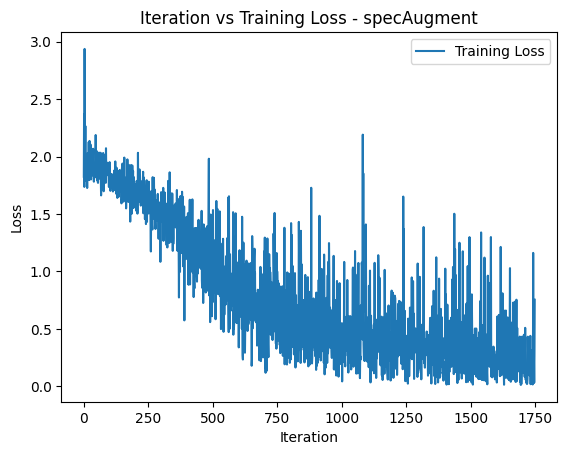

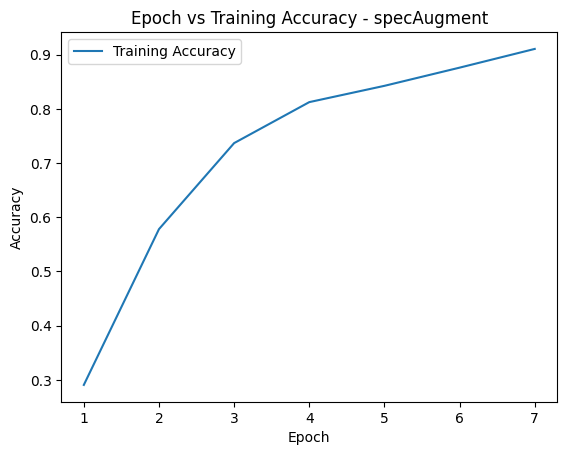

In [ ]:
# Plot Iteration vs Training Loss
plt.plot(train_loss, label="Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Iteration vs Training Loss - specAugment")
plt.legend()
plt.show()

# Plot Epoch vs Training Accuracy
acc_X = np.arange(len(train_accuracies))+1
plt.plot(acc_X, train_accuracies,"-", label="Training Accuracy")
plt.xticks(acc_X)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Epoch vs Training Accuracy - specAugment")
plt.legend()
plt.show()

**Save model**

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')
# Save model and feature extractor to Drive
save_path = f"{BASE_DIR}/Augmented models/specAugment"
model.save_pretrained(save_path)
feature_extractor.save_pretrained(save_path)

# Verify the save was successful
import os
saved_files = os.listdir(save_path)
print("Saved files:", saved_files)

Mounted at /content/drive
Saved files: ['config.json', 'model.safetensors', 'preprocessor_config.json']


## 6. Testing

### **Testing on clean Test Set**

**Retrieve predictions**

In [ ]:
# Testing
from torch.utils.data import DataLoader

# Get test data by DataLoader
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Start testing
# model.eval()
model.eval()

with torch.no_grad():
   correct = 0
   count = 0
   record = {"labels":[], "predictions":[]}

   pbar = tqdm(test_loader)
   for batch in pbar:
       input_ids = batch['input_values'].to(device)
       attention_mask = batch['attention_mask'].to(device)
       labels = batch['labels'].to(device)
       #outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
       outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
       loss = outputs['loss']

       predictions = predict(outputs)
       correct += predictions.eq(labels).sum().item()
       count += len(labels)
       accuracy = correct / count

       pbar.set_postfix({
           'loss': f'{loss.item():.3f}',
           'accuracy': f'{accuracy:.3f}'
       })

       record["labels"] += labels.cpu().numpy().tolist()
       record["predictions"] += predictions.cpu().numpy().tolist()

   pbar.close()

print(f"\nFinal test accuracy: {accuracy*100:.4f}%")

100%|██████████| 250/250 [00:22<00:00, 10.93it/s, loss=1.272, accuracy=0.872]


Final test accuracy: 87.2000%


**Analysis of the results**

In [ ]:
# Analysis
df_record = pd.DataFrame(record)
df_record.columns = ["Ground Truth", "Model Prediction"]

emotions = ["neutral", "happy", "sad", "angry", "fear", "disgust", "surprise"]
df_record["Ground Truth"] = df_record["Ground Truth"].apply(lambda x: emotions[x])
df_record["Model Prediction"] = df_record["Model Prediction"].apply(lambda x: emotions[x])

In [ ]:
# Concat test texts and test records
df = pd.concat([test_df.reset_index(), df_record["Model Prediction"]], axis=1)
#df["emotion"] = df.apply(lambda x: x["emotion"][:3], axis=1)

# Show incorrect predictions
incorrect_predictions = df[df["emotion"] != df["Model Prediction"]]
incorrect_predictions.head(10)

,index,gender,emotion,labels,source,path,aug_type,aug_params,Model Prediction
7,1437,female,surprise,8,RAVDESS,./Audio_Speech_Actors_01-24/Actor_24/03-01-08-...,clean,None,happy
17,57,male,sad,4,RAVDESS,./Audio_Speech_Actors_01-24/Actor_01/03-01-04-...,clean,None,neutral
23,25,male,sad,4,RAVDESS,./Audio_Speech_Actors_01-24/Actor_01/03-01-04-...,clean,None,neutral
31,847,male,sad,4,RAVDESS,./Audio_Speech_Actors_01-24/Actor_15/03-01-04-...,clean,None,happy
39,765,male,surprise,8,RAVDESS,./Audio_Speech_Actors_01-24/Actor_13/03-01-08-...,clean,None,happy
60,995,male,angry,5,RAVDESS,./Audio_Speech_Actors_01-24/Actor_17/03-01-05-...,clean,None,sad
63,645,male,happy,3,RAVDESS,./Audio_Speech_Actors_01-24/Actor_11/03-01-03-...,clean,None,neutral
65,499,male,disgust,7,RAVDESS,./Audio_Speech_Actors_01-24/Actor_09/03-01-07-...,clean,None,sad
73,1225,male,happy,3,RAVDESS,./Audio_Speech_Actors_01-24/Actor_21/03-01-03-...,clean,None,neutral
94,883,male,surprise,8,RAVDESS,./Audio_Speech_Actors_01-24/Actor_15/03-01-08-...,clean,None,disgust


**Lets look at incorrect predictions**

In [ ]:
samples = incorrect_predictions.sample(n=3, random_state=42)
# Loop through the selected samples and display information
for idx, row in samples.iterrows():
    print(f"Sample {idx}:")
    print(f"True Emotion: {row['emotion']}")
    print(f"Predicted Emotion: {row['Model Prediction']}")
    print("Audio:")
    ipd.display(ipd.Audio(data=row["path"], autoplay=False, rate=16000))
    print("-" * 50)

Sample 210:
True Emotion: happy
Predicted Emotion: angry
Audio:


--------------------------------------------------
Sample 229:
True Emotion: fear
Predicted Emotion: surprise
Audio:


--------------------------------------------------
Sample 11:
True Emotion: happy
Predicted Emotion: surprise
Audio:


--------------------------------------------------


**Classification report**

In [ ]:
print("\nClassification Report on clean data - Noise:")
report = classification_report(
    df_record["Ground Truth"],
    df_record["Model Prediction"],
    target_names=emotions
)
print(report)


Classification Report on clean data - Noise:
              precision    recall  f1-score   support

     neutral       1.00      0.89      0.94        38
       happy       0.92      0.92      0.92        38
         sad       0.93      1.00      0.96        39
       angry       0.81      0.77      0.79        39
        fear       0.58      0.95      0.72        19
     disgust       0.88      0.74      0.81        39
    surprise       0.94      0.87      0.90        38

    accuracy                           0.87       250
   macro avg       0.87      0.88      0.86       250
weighted avg       0.89      0.87      0.87       250



**Confusion Matrix**

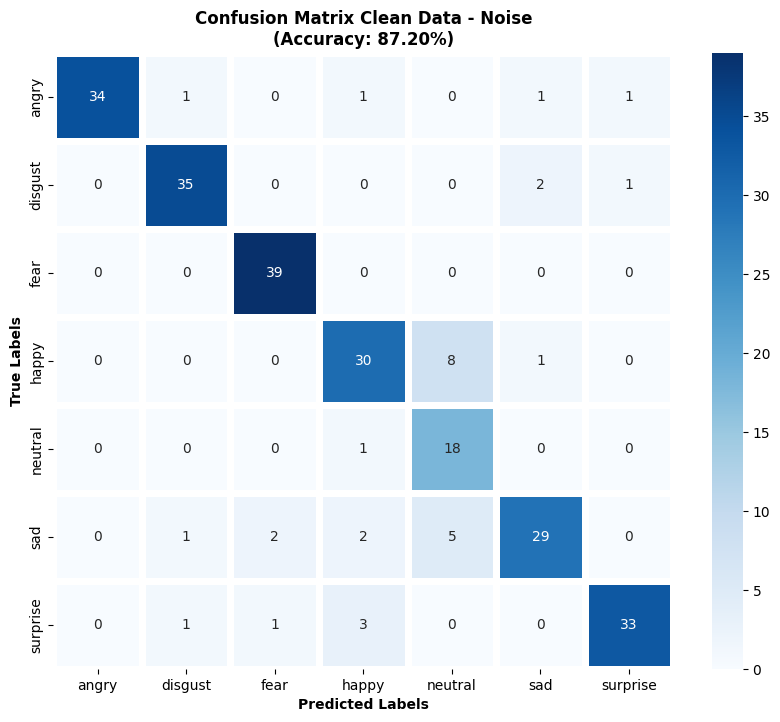

In [ ]:
# Confusion Matrix
crosstab = pd.crosstab(df_record["Ground Truth"], df_record["Model Prediction"])
plt.figure(figsize=(10, 8))
sns.heatmap(crosstab, cmap='Blues', annot=True, fmt='g', linewidths=5)
accuracy = df_record["Ground Truth"].eq(df_record["Model Prediction"]).sum() / len(df_record)
plt.title(f"Confusion Matrix Clean Data - Noise\n(Accuracy: {accuracy*100:.2f}%)", fontweight='bold')
plt.ylabel("True Labels", fontweight='bold')
plt.xlabel("Predicted Labels", fontweight='bold')
plt.show()

### **Testing on Augmented Test Set**



=== Testing on Augmented Test Set ===



Map:   0%|          | 0/250 [00:00<?, ? examples/s]

100%|██████████| 250/250 [00:23<00:00, 10.86it/s, loss=1.408, accuracy=0.876]


Final augmented test accuracy: 87.6000%

Incorrect predictions for augmented test set:
    index  gender   emotion  labels   source  \
7       7  female  surprise       8  RAVDESS   
17     17    male       sad       4  RAVDESS   
23     23    male       sad       4  RAVDESS   
31     31    male       sad       4  RAVDESS   
39     39    male  surprise       8  RAVDESS   
60     60    male     angry       5  RAVDESS   
63     63    male     happy       3  RAVDESS   
65     65    male   disgust       7  RAVDESS   
73     73    male     happy       3  RAVDESS   
94     94    male  surprise       8  RAVDESS   

                                                 path      aug_type  \
7   augmented/test/spec_augment/1437_time10_freq30...  spec_augment   
17  augmented/test/spec_augment/57_time30_freq30_s...  spec_augment   
23  augmented/test/spec_augment/25_time30_freq30_s...  spec_augment   
31  augmented/test/spec_augment/847_time30_freq30_...  spec_augment   
39  augmented/test/spec_augme

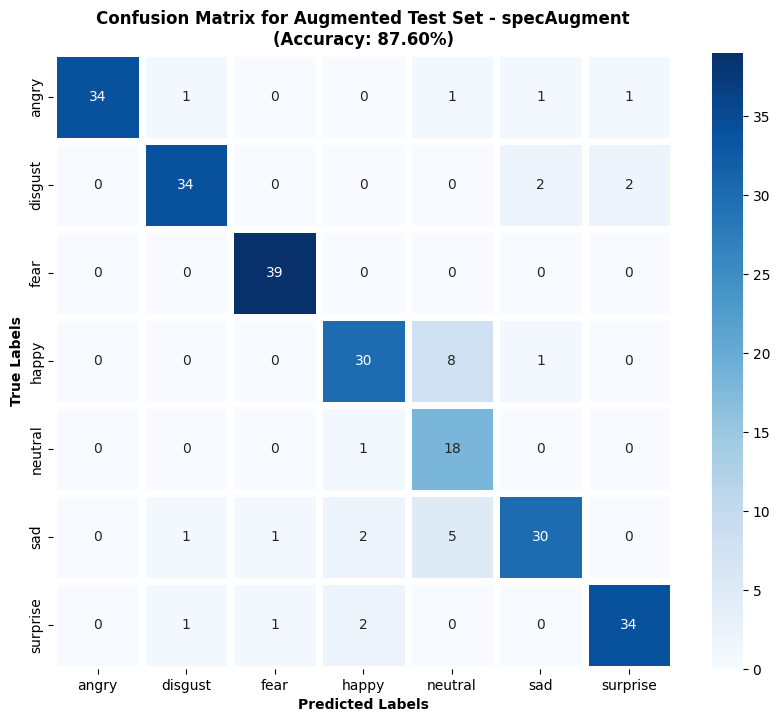

In [ ]:
print("\n=== Testing on Augmented Test Set ===\n")

# Get augmented test data by DataLoader
test_data_aug = Dataset.from_pandas(test_spec_df).map(map_to_array)
test_aug_encodings = feature_extractor(list(test_data_aug["speech"]), sampling_rate=16000, padding=True, return_tensors="pt")
test_dataset_aug = EmotionDataset(test_aug_encodings, list(test_data_aug["labels"]))
test_loader_aug = DataLoader(test_dataset_aug, batch_size=1, shuffle=False)

# Start testing on augmented data
model.eval()

with torch.no_grad():
    correct = 0
    count = 0
    record = {"labels":[], "predictions":[]}

    pbar = tqdm(test_loader_aug)
    for batch in pbar:
        input_ids = batch['input_values'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs['loss']

        predictions = predict(outputs)
        correct += predictions.eq(labels).sum().item()
        count += len(labels)
        accuracy = correct / count

        pbar.set_postfix({
            'loss': f'{loss.item():.3f}',
            'accuracy': f'{accuracy:.3f}'
        })

        record["labels"] += labels.cpu().numpy().tolist()
        record["predictions"] += predictions.cpu().numpy().tolist()

    pbar.close()

print(f"Final augmented test accuracy: {accuracy*100:.4f}%")

# Analysis for augmented test set
df_record_aug = pd.DataFrame(record)
df_record_aug.columns = ["Ground Truth", "Model Prediction"]

df_record_aug["Ground Truth"] = df_record_aug["Ground Truth"].apply(lambda x: emotions[x])
df_record_aug["Model Prediction"] = df_record_aug["Model Prediction"].apply(lambda x: emotions[x])

# Concat test texts and test records for augmented data
df_aug = pd.concat([test_spec_df.reset_index(), df_record_aug["Model Prediction"]], axis=1)

# Show incorrect predictions for augmented data
incorrect_predictions_aug = df_aug[df_aug["emotion"] != df_aug["Model Prediction"]]
print("\nIncorrect predictions for augmented test set:")
print(incorrect_predictions_aug.head(10))

print("\nClassification Report for Augmented Test Set:")
report_aug = classification_report(
    df_record_aug["Ground Truth"],
    df_record_aug["Model Prediction"],
    target_names=emotions
)
print(report_aug)

# Confusion Matrix for augmented test set
plt.figure(figsize=(10, 8))
crosstab_aug = pd.crosstab(df_record_aug["Ground Truth"], df_record_aug["Model Prediction"])
sns.heatmap(crosstab_aug, cmap='Blues', annot=True, fmt='g', linewidths=5)
accuracy_aug = df_record_aug["Ground Truth"].eq(df_record_aug["Model Prediction"]).sum() / len(df_record_aug)
plt.title(f"Confusion Matrix for Augmented Test Set - specAugment\n(Accuracy: {accuracy_aug*100:.2f}%)", fontweight='bold')
plt.ylabel("True Labels", fontweight='bold')
plt.xlabel("Predicted Labels", fontweight='bold')
plt.show()

### **Testing on Clean + Augmented Test Set**


=== Testing on Clean + Augmented Test Set ===



Map:   0%|          | 0/500 [00:00<?, ? examples/s]

100%|██████████| 500/500 [00:45<00:00, 10.88it/s, loss=1.408, accuracy=0.874]


Final augmented test accuracy: 87.4000%

Incorrect predictions for augmented test set:
    index  gender   emotion  labels   source  \
7       7  female  surprise       8  RAVDESS   
17     17    male       sad       4  RAVDESS   
23     23    male       sad       4  RAVDESS   
31     31    male       sad       4  RAVDESS   
39     39    male  surprise       8  RAVDESS   
60     60    male     angry       5  RAVDESS   
63     63    male     happy       3  RAVDESS   
65     65    male   disgust       7  RAVDESS   
73     73    male     happy       3  RAVDESS   
94     94    male  surprise       8  RAVDESS   

                                                 path aug_type aug_params  \
7   ./Audio_Speech_Actors_01-24/Actor_24/03-01-08-...    clean       None   
17  ./Audio_Speech_Actors_01-24/Actor_01/03-01-04-...    clean       None   
23  ./Audio_Speech_Actors_01-24/Actor_01/03-01-04-...    clean       None   
31  ./Audio_Speech_Actors_01-24/Actor_15/03-01-04-...    clean       None   

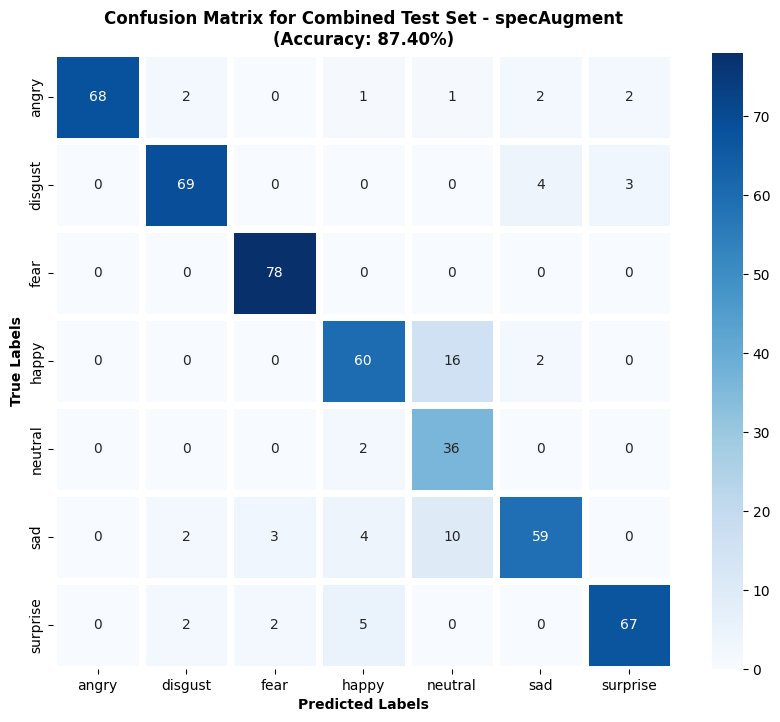

In [ ]:
print("\n=== Testing on Clean + Augmented Test Set ===\n")

# Get augmented test data by DataLoader
test_data_aug = Dataset.from_pandas(test_combined_spec).map(map_to_array)
test_aug_encodings = feature_extractor(list(test_data_aug["speech"]), sampling_rate=16000, padding=True, return_tensors="pt")
test_dataset_aug = EmotionDataset(test_aug_encodings, list(test_data_aug["labels"]))
test_loader_aug = DataLoader(test_dataset_aug, batch_size=1, shuffle=False)

# Start testing on augmented data
model.eval()

with torch.no_grad():
    correct = 0
    count = 0
    record = {"labels":[], "predictions":[]}

    pbar = tqdm(test_loader_aug)
    for batch in pbar:
        input_ids = batch['input_values'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs['loss']

        predictions = predict(outputs)
        correct += predictions.eq(labels).sum().item()
        count += len(labels)
        accuracy = correct / count

        pbar.set_postfix({
            'loss': f'{loss.item():.3f}',
            'accuracy': f'{accuracy:.3f}'
        })

        record["labels"] += labels.cpu().numpy().tolist()
        record["predictions"] += predictions.cpu().numpy().tolist()

    pbar.close()

print(f"Final augmented test accuracy: {accuracy*100:.4f}%")

# Analysis for augmented test set
df_record_aug = pd.DataFrame(record)
df_record_aug.columns = ["Ground Truth", "Model Prediction"]

df_record_aug["Ground Truth"] = df_record_aug["Ground Truth"].apply(lambda x: emotions[x])
df_record_aug["Model Prediction"] = df_record_aug["Model Prediction"].apply(lambda x: emotions[x])

# Concat test texts and test records for augmented data
df_aug = pd.concat([test_combined_spec.reset_index(), df_record_aug["Model Prediction"]], axis=1)

# Show incorrect predictions for augmented data
incorrect_predictions_aug = df_aug[df_aug["emotion"] != df_aug["Model Prediction"]]
print("\nIncorrect predictions for augmented test set:")
print(incorrect_predictions_aug.head(10))

print("\nClassification Report for Combined Test Set - specAugment:")
report_aug = classification_report(
    df_record_aug["Ground Truth"],
    df_record_aug["Model Prediction"],
    target_names=emotions
)
print(report_aug)

# Confusion Matrix for augmented test set
plt.figure(figsize=(10, 8))
crosstab_aug = pd.crosstab(df_record_aug["Ground Truth"], df_record_aug["Model Prediction"])
sns.heatmap(crosstab_aug, cmap='Blues', annot=True, fmt='g', linewidths=5)
accuracy_aug = df_record_aug["Ground Truth"].eq(df_record_aug["Model Prediction"]).sum() / len(df_record_aug)
plt.title(f"Confusion Matrix for Combined Test Set - specAugment\n(Accuracy: {accuracy_aug*100:.2f}%)", fontweight='bold')
plt.ylabel("True Labels", fontweight='bold')
plt.xlabel("Predicted Labels", fontweight='bold')
plt.show()

## 7. Testing all test sets

Loading the model and all test sets for evaluation.

Load the specAugmented model

In [ ]:
# Load model and feature extractor from the saved path
model_path = f"{BASE_DIR}/Augmented models/specAugment"
model = HubertForSequenceClassification.from_pretrained(model_path)
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(model_path)
model.to(device)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


HubertForSequenceClassification(
  (hubert): HubertModel(
    (feature_extractor): HubertFeatureEncoder(
      (conv_layers): ModuleList(
        (0): HubertLayerNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation): GELUActivation()
        )
        (1-4): 4 x HubertLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation): GELUActivation()
        )
        (5-6): 2 x HubertLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation): GELUActivation()
        )
      )
    )
    (feature_projection): HubertFeatureProjection(
      (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (pro

Load the test sets

In [ ]:
import os
import shutil
import pandas as pd
import pickle

def load_test_sets(base_dir='test_sets_backup'):
    """
    Loads all saved test sets and restores original naming with spaces.
    """
    loaded_sets = {}

    # Go through each folder in the base directory
    for set_folder in os.listdir(base_dir):
        if os.path.isdir(os.path.join(base_dir, set_folder)):
            # Load the DataFrame
            df_path = os.path.join(base_dir, set_folder, 'metadata.pkl')
            if os.path.exists(df_path):
                # Convert folder name back to original format (replace underscores with spaces)
                original_name = set_folder.replace('_', ' ')
                loaded_sets[original_name] = pd.read_pickle(df_path)

    return loaded_sets

In [ ]:
# Load all test sets
loaded_test_sets = load_test_sets(f"{BASE_DIR}/Datasets/RAVDNESS")

# Select only relevant test sets for noise model
noise_relevant_sets = {
    'Clean': loaded_test_sets['Clean'],
    'SpecAugment': loaded_test_sets['SpecAugment'],
    'Combined SpecAugment': loaded_test_sets['Combined SpecAugment']
}

**Function to test a single test set**

In [ ]:
def evaluate_test_set(model, test_df, set_name, device, feature_extractor):
    """
    Evaluates model performance on a given test set and generates analysis

    Args:
        model: The trained model
        test_df: DataFrame containing test data
        set_name: String identifying the test set (e.g., 'Noise', 'Time Stretch')
        emotions: List of emotion labels
        device: torch device
        feature_extractor: HuBERT feature extractor
    """
    # Ensure model is in eval mode and gradients are disabled
    model.eval()
    for param in model.parameters():
        param.requires_grad = False

    # Prepare data
    test_data = Dataset.from_pandas(test_df).map(map_to_array)
    test_encodings = feature_extractor(
        list(test_data["speech"]),
        sampling_rate=16000,
        padding=True,
        return_tensors="pt"
    )
    test_dataset = EmotionDataset(test_encodings, list(test_data["labels"]))
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

    # Testing loop
    with torch.no_grad():
        correct = 0
        count = 0
        record = {"labels": [], "predictions": []}

        pbar = tqdm(test_loader, desc=f"Testing {set_name}")
        for batch in pbar:
            input_ids = batch['input_values'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)

            predictions = predict(outputs)
            correct += predictions.eq(labels).sum().item()
            count += len(labels)
            accuracy = correct / count

            pbar.set_postfix({
                'loss': f'{outputs["loss"].item():.3f}',
                'accuracy': f'{accuracy:.3f}'
            })

            record["labels"] += labels.cpu().numpy().tolist()
            record["predictions"] += predictions.cpu().numpy().tolist()

        pbar.close()

    # Analysis
    df_record = pd.DataFrame(record)
    df_record.columns = ["Ground Truth", "Model Prediction"]
    emotions = ["neutral", "happy", "sad", "angry", "fear", "disgust", "surprise"]
    df_record["Ground Truth"] = df_record["Ground Truth"].apply(lambda x: emotions[x])
    df_record["Model Prediction"] = df_record["Model Prediction"].apply(lambda x: emotions[x])

    # Results printing
    print(f"\n=== Results for {set_name} ===")
    print(f"Final accuracy: {accuracy*100:.4f}%")

    # Classification report
    print(f"\nClassification Report for specAugment model on {set_name} test set:")
    report = classification_report(
        df_record["Ground Truth"],
        df_record["Model Prediction"],
        target_names=emotions
    )
    print(report)

    # Confusion Matrix
    plt.figure(figsize=(10, 8))
    crosstab = pd.crosstab(df_record["Ground Truth"], df_record["Model Prediction"])
    sns.heatmap(crosstab, cmap='Blues', annot=True, fmt='g', linewidths=5)
    plt.title(f"Confusion Matrix for specAugment model - {set_name} test set\n(Accuracy: {accuracy*100:.2f}%)",
              fontweight='bold')
    plt.ylabel("True Labels", fontweight='bold')
    plt.xlabel("Predicted Labels", fontweight='bold')
    plt.show()

    return accuracy, df_record

**All test datasets saved**


Evaluating specAugment Model on Clean dataset...


Map:   0%|          | 0/250 [00:00<?, ? examples/s]

Testing Clean: 100%|██████████| 250/250 [00:21<00:00, 11.50it/s, loss=1.314, accuracy=0.908]



=== Results for Clean ===
Final accuracy: 90.8000%

Classification Report for specAugment model on Clean test set:
              precision    recall  f1-score   support

     neutral       0.97      0.92      0.95        38
       happy       1.00      0.89      0.94        38
         sad       0.97      1.00      0.99        39
       angry       0.85      0.90      0.88        39
        fear       0.64      0.95      0.77        19
     disgust       0.94      0.85      0.89        39
    surprise       0.92      0.87      0.89        38

    accuracy                           0.91       250
   macro avg       0.90      0.91      0.90       250
weighted avg       0.92      0.91      0.91       250



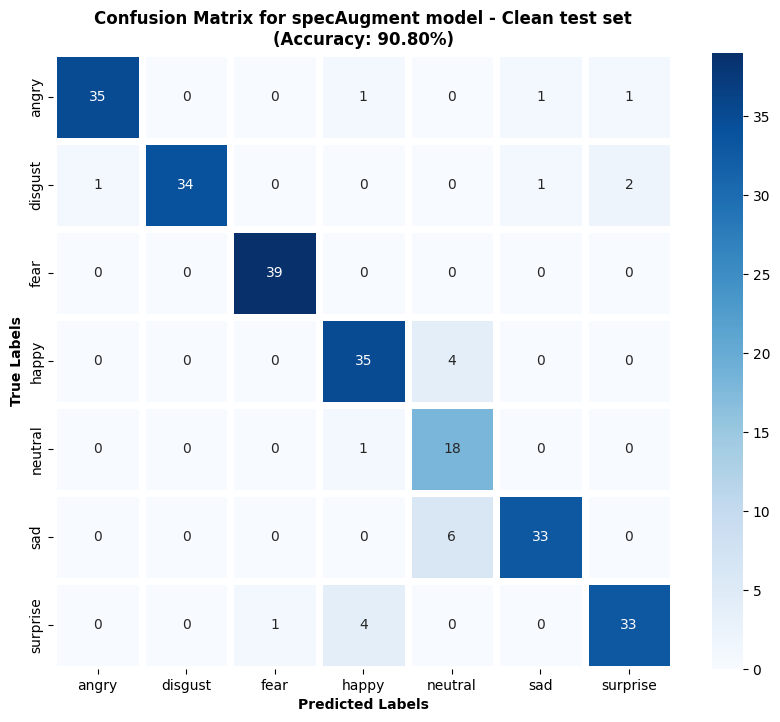


Evaluating specAugment Model on SpecAugment dataset...


Map:   0%|          | 0/250 [00:00<?, ? examples/s]

Testing SpecAugment: 100%|██████████| 250/250 [00:21<00:00, 11.45it/s, loss=1.636, accuracy=0.912]



=== Results for SpecAugment ===
Final accuracy: 91.2000%

Classification Report for specAugment model on SpecAugment test set:
              precision    recall  f1-score   support

     neutral       1.00      0.92      0.96        38
       happy       1.00      0.89      0.94        38
         sad       0.97      1.00      0.99        39
       angry       0.87      0.87      0.87        39
        fear       0.64      0.95      0.77        19
     disgust       0.94      0.87      0.91        39
    surprise       0.89      0.89      0.89        38

    accuracy                           0.91       250
   macro avg       0.90      0.91      0.90       250
weighted avg       0.92      0.91      0.91       250



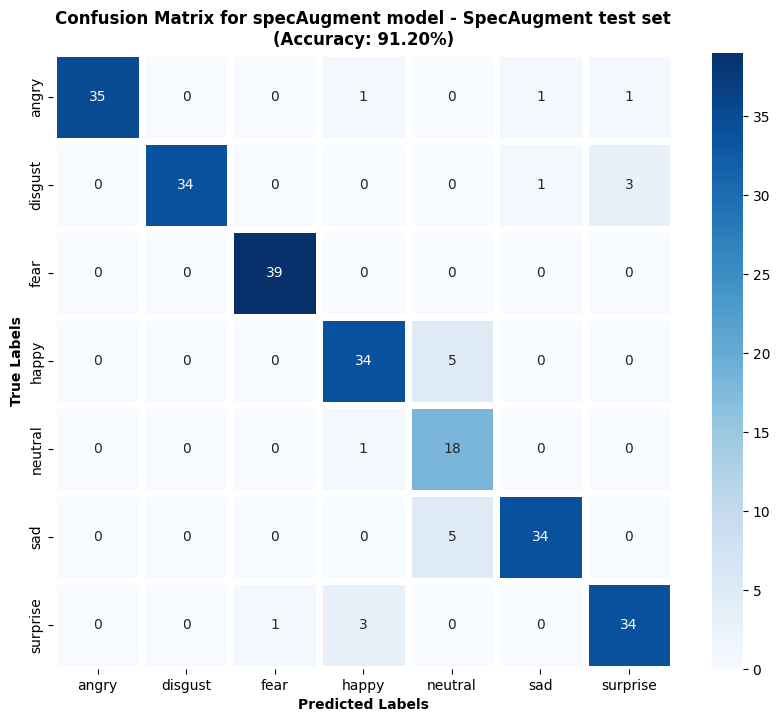


Evaluating specAugment Model on Combined SpecAugment dataset...


Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Testing Combined SpecAugment: 100%|██████████| 500/500 [00:44<00:00, 11.24it/s, loss=1.636, accuracy=0.910]



=== Results for Combined SpecAugment ===
Final accuracy: 91.0000%

Classification Report for specAugment model on Combined SpecAugment test set:
              precision    recall  f1-score   support

     neutral       0.99      0.92      0.95        76
       happy       1.00      0.89      0.94        76
         sad       0.97      1.00      0.99        78
       angry       0.86      0.88      0.87        78
        fear       0.64      0.95      0.77        38
     disgust       0.94      0.86      0.90        78
    surprise       0.91      0.88      0.89        76

    accuracy                           0.91       500
   macro avg       0.90      0.91      0.90       500
weighted avg       0.92      0.91      0.91       500



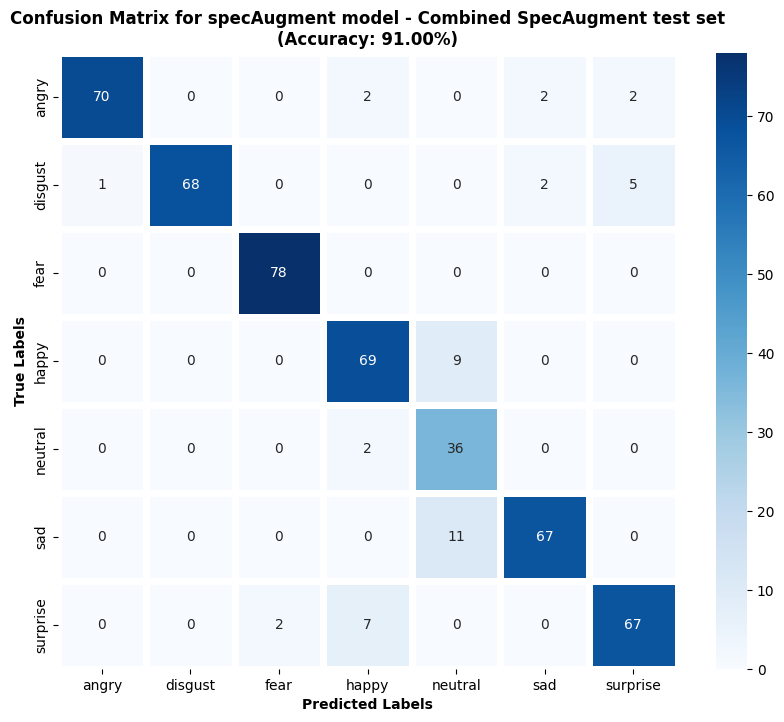

In [ ]:
# Evaluate noise model only on relevant sets
results = {}
for set_name, test_data in noise_relevant_sets.items():
    print(f"\nEvaluating specAugment Model on {set_name} dataset...")
    accuracy, df_record = evaluate_test_set(
        model,
        test_data,
        set_name,
        device,
        feature_extractor
    )
    results[set_name] = {'accuracy': accuracy, 'record': df_record}